In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math 
import cv2

import os 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Flatten, Dropout


In [3]:
# Initialize lists to store images and labels
X = []
Y = []
# Define directories for the two classes: "no" and "yes"
dirs = ['./brain_tumor_dataset/no','./brain_tumor_dataset/yes']
# Iterate over directories
for i in dirs:
    path = i
    # Iterate over images in each directory
    for x in os.listdir(path):
        # Read, resize, and convert images to grayscale
        img = cv2.imread(path + '/'+ x)
        img = cv2.resize(img,(128, 128), interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape(128,128,1)
        X.append(img)
        Y.append(i)
# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)
print("Shape of X: ", np.shape(X))
print("Shape of Y: ", np.shape(Y))

Shape of X:  (253, 128, 128, 1)
Shape of Y:  (253,)


In [4]:
# normalize images
X = (X.astype(np.float32) - 127.5)/127.5
# reshape images
X = X.reshape(253, 128*128)
print("Shape of X: ", np.shape(X))

Shape of X:  (253, 16384)


In [5]:
#Building the generator model of the GAN
generator_model = Sequential([
    Dense(256, input_shape=(100,)),
    BatchNormalization(),
    LeakyReLU(0.2),
    Reshape((16, 16, 1)),
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])
# Print summary of the generator model
generator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 1)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       3200      
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       5

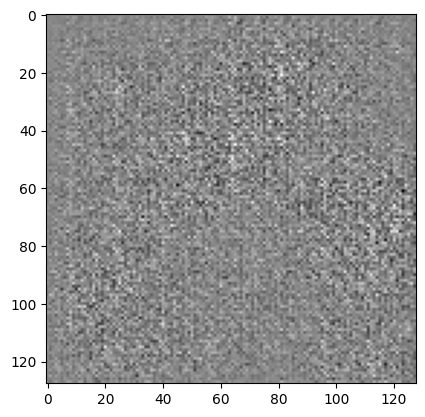

In [6]:
#sample untrained generator
sample_vector = tf.random.normal([1, 100])
sample_image = generator_model(sample_vector, training=False)
plt.imshow(sample_image[0, :, :, 0], cmap='gray')

In [7]:
#Building the discriminator model of the GAN
discriminator_model = Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(1)
])
# Print summary of the discriminator model
discriminator_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 64, 64, 64)       

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.legacy.Adam()
discriminator_optimizer = tf.keras.optimizers.legacy.Adam()

def training_step(images):
    noise = tf.random.normal([tf.shape(images)[0], 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_model(noise, training=True)
        real_output = discriminator_model(images, training=True)
        fake_output = discriminator_model(generated_images, training=True)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))
    return gen_loss, disc_loss

In [13]:
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

epochs = 3000
batch_size = 32
gen_loss_history = []
disc_loss_history = []

# Define the image generator
datagen = ImageDataGenerator(
rotation_range=20, # Random rotation range (in degrees)
width_shift_range=0.1, # Random horizontal shift range (as a fraction of total width)
height_shift_range=0.1, # Random vertical shift range (as a fraction of total height)
shear_range=0.2, # Random shear range
zoom_range=0.2, # Random zoom range
horizontal_flip=True, # Random horizontal flip
fill_mode='nearest' # Fill strategy for pixels outside the original image boundaries
)

# Reshape the data so that ImageDataGenerator can accept it
X = X.reshape(-1, 128, 128, 1)

# Iterator augmented images
augmented_images = datagen.flow(X, batch_size=batch_size)

print("Number of augmented_images: ", augmented_images.n)

Number of augmented_images:  253


In [14]:
# Training with augmented images
for epoch in range(epochs):
    start_time = time.time()
    for i in range(0, len(X), batch_size):
        batch_images = next(augmented_images)
        gen_loss, disc_loss = training_step(batch_images)
        gen_loss_history.append(gen_loss)
        disc_loss_history.append(disc_loss)
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start_time))

Time for epoch 1 is 9.972327947616577 sec
Time for epoch 2 is 8.724416971206665 sec
Time for epoch 3 is 8.394698858261108 sec
Time for epoch 4 is 8.577023983001709 sec
Time for epoch 5 is 8.419548273086548 sec
Time for epoch 6 is 8.481292009353638 sec
Time for epoch 7 is 8.600775957107544 sec
Time for epoch 8 is 8.922696113586426 sec
Time for epoch 9 is 8.707435846328735 sec
Time for epoch 10 is 8.80768895149231 sec
Time for epoch 11 is 10.30288577079773 sec
Time for epoch 12 is 9.01401400566101 sec
Time for epoch 13 is 8.508036136627197 sec
Time for epoch 14 is 9.004618167877197 sec
Time for epoch 15 is 8.825864791870117 sec
Time for epoch 16 is 8.73473572731018 sec
Time for epoch 17 is 8.657604932785034 sec
Time for epoch 18 is 8.558324098587036 sec
Time for epoch 19 is 9.105573892593384 sec
Time for epoch 20 is 8.615831136703491 sec
Time for epoch 21 is 8.531701803207397 sec
Time for epoch 22 is 8.59897518157959 sec
Time for epoch 23 is 8.513296127319336 sec
Time for epoch 24 is 8.6

In [15]:
# Generating 16 sample vectors
sample_vectors = tf.random.normal(shape=(16, 100))

# Generating images from the generator
generated_images = generator_model(sample_vectors, training=False)

# Normalizing the pixels in the generated images
generated_images = (generated_images * 127.5) + 127.5  

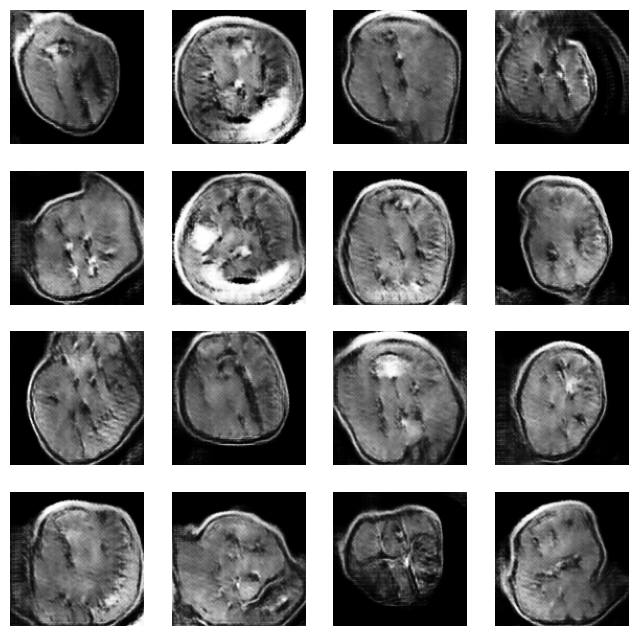

In [16]:
# Plotting the generated images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()


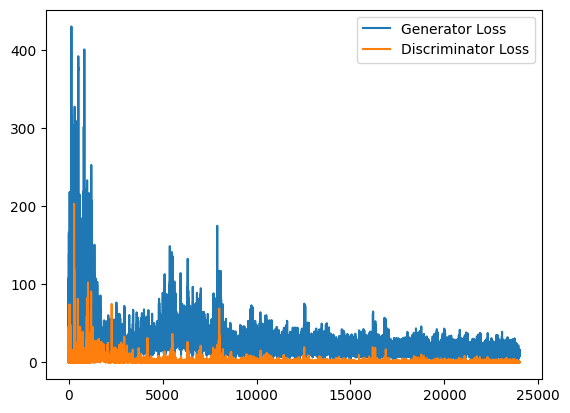

In [17]:
#plotting the loss history of the generator and discriminator
plt.plot(gen_loss_history, label='Generator Loss')
plt.plot(disc_loss_history, label='Discriminator Loss')
plt.legend()
plt.show()